# Анализ разметки открытого датасета [DeepGlobe](https://competitions.codalab.org/competitions/18468)

In [1]:
import sys
sys.path.append('../')

from matplotlib import pyplot as plt 

import numpy as np
from tqdm import tqdm
import batchflow as bf

Исходная разметка:

* Urban land: 0,255,255 - Man-made, built up areas with human artifacts (can ignore roads for now which is hard to label)
* Agriculture land: 255,255,0 - Farms, any planned (i.e. regular) plantation, cropland, orchards, vineyards, nurseries, and ornamental horticultural areas; confined feeding operations.
* Rangeland: 255,0,255 - Any non-forest, non-farm, green land, grass
* Forest land: 0,255,0 - Any land with x% tree crown density plus clearcuts.
* Water: 0,0,255 - Rivers, oceans, lakes, wetland, ponds.
* Barren land: 255,255,255 - Mountain, land, rock, dessert, beach, no vegetation
* Unknown: 0,0,0 - Clouds and others

In [2]:
# Another representation 
# 0 Unknown: [0,0,0]
# 1 Water: [0,0,255]
# 2 Forest land: [0,255,0]
# 3 Urban land: [0,255,255]
# 4
# 5 Rangeland: [255,0,255]
# 6 Agriculture land: [255,255,0]
# 7 Barren land: [255,255,255]

In [3]:
classes = ['Unknown', 'Water', 'Forest land', 'Urban land', '', 'Rangeland', 'Agriculture land', 'Barren land']

In [4]:
def to_class(mask, multiplier=255, axis=-1):
    """
    Transforms mask with RGB-encoded label to mask with class numbers.
    """
    mask = (mask // multiplier) # to binary
    base = 2 ** np.arange(mask.shape[axis])[::-1] # binary base
    return (mask * base).sum(axis=axis, keepdims=True)

Индексируем маски и создаём датасет:

In [5]:
mask_index = bf.FilesIndex(path='../ignore/Landcover/train/*.png', no_ext=True)
ds = bf.Dataset(mask_index, bf.ImagesBatch)

Пробегаемся по всем маскам, считая количество пикселей для каждого класса:

In [6]:
bsize = 10
counts = np.zeros(len(classes))
for _ in tqdm(range(len(ds) // bsize + 1)):
    batch = ds.next_batch(bsize).load(fmt='image', components=['images']).to_array()
    q = to_class(np.concatenate(batch.images))
    counts += np.bincount(q.flatten(), minlength=8)

100%|██████████| 81/81 [04:12<00:00,  2.48s/it]


In [7]:
ratios = counts / counts.sum() * 100

Соотношение классов в датасете:

In [8]:
for cls, ratio in zip(classes, ratios):
    print('{cls}: {0:.2f}%'.format(ratio, cls=cls))

Unknown: 0.05%
Water: 3.31%
Forest land: 11.16%
Urban land: 10.80%
: 0.00%
Rangeland: 8.48%
Agriculture land: 57.74%
Barren land: 8.45%


<BarContainer object of 8 artists>

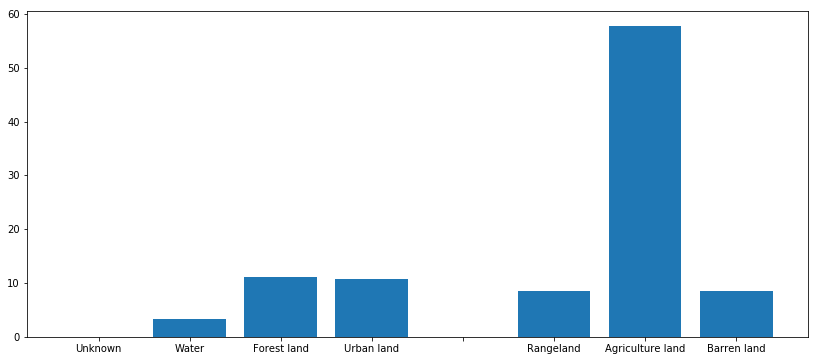

In [9]:
plt.figure(figsize=(14,6))
plt.bar(classes, counts/counts.sum()*100)